Prescriptive Analytics for Capacity, Pricing, and Planning at OptiLogix

Imagine you’re working as an operations analyst at OptiLogix, a regional retailer. The company faces several planning challenges:

How to allocate shipments from two warehouses to three markets at the lowest possible cost.

Which promotional bundles to select under a fixed budget.

What price should be set to maximize profit given demand elasticity.

How to stress test the plan under demand uncertainty.

Your task is to build a prescriptive analytics pipeline that combines linear programming, integer optimization, nonlinear pricing, and Monte Carlo simulation.

SECTION 1: Simulate Planning Inputs

In [ ]:
import numpy as np
import pandas as pd

# Warehouses and capacities
warehouses = pd.DataFrame({
    "wh": ["W1","W2"],
    "capacity": [900, 700]
})

# Markets and demands
markets = pd.DataFrame({
    "mkt": ["North","Central","South"],
    "demand": [600, 500, 400]
})

# Per unit shipping cost
cost = pd.DataFrame({
    "W1": [6.0, 7.0, 9.0],
    "W2": [8.0, 6.0, 5.5]
}, index=markets["mkt"])

# Promo bundles
bundles = pd.DataFrame({
    "bundle": ["A","B","C","D","E","F"],
    "cost":   [40, 55, 35, 60, 25, 45],
    "uplift": [60, 85, 45, 90, 35, 55]
})
promo_budget = 150  # budget in thousands

# Pricing setup
price_min, price_max = 40.0, 120.0
marginal_cost = 35.0
baseline_demand = 1800
ref_price = 80.0
elasticity = 0.015


SECTION 2: Linear Programming for Shipment Allocation

In [ ]:
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Decision variable order: W1->North, W1->Central, W1->South, W2->North, W2->Central, W2->South
c = [cost.loc["North","W1"], cost.loc["Central","W1"], cost.loc["South","W1"],
     cost.loc["North","W2"], cost.loc["Central","W2"], cost.loc["South","W2"]]

# Constraints
A_eq = [[1,0,0, 1,0,0],
        [0,1,0, 0,1,0],
        [0,0,1, 0,0,1]]
b_eq = markets["demand"].values

A_ub = [[1,1,1, 0,0,0],
        [0,0,0, 1,1,1]]
b_ub = warehouses["capacity"].values

res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, None), method="highs")
print("Shipment allocation:", res.x)
print("Total shipping cost:", res.fun)


Shipment allocation: [600. 200.   0.   0. 300. 400.]
Total shipping cost: 9000.0


SECTION 3: Integer Programming for Promo Selection

In [ ]:
# Simple knapsack dynamic programming
def knapsack(costs, values, budget):
    n = len(costs)
    dp = [0]*(budget+1)
    keep = [[False]*(budget+1) for _ in range(n)]
    for i in range(n):
        for b in range(budget, costs[i]-1, -1):
            if dp[b-costs[i]] + values[i] > dp[b]:
                dp[b] = dp[b-costs[i]] + values[i]
                keep[i][b] = True
    chosen, b = [], budget
    for i in range(n-1,-1,-1):
        if keep[i][b]:
            chosen.append(i)
            b -= costs[i]
    return list(reversed(chosen)), dp[budget]

chosen, uplift = knapsack(bundles["cost"].tolist(), bundles["uplift"].tolist(), promo_budget)
print("Bundles chosen:", bundles.iloc[chosen])
print("Total uplift (k):", uplift)


Bundles chosen:   bundle  cost  uplift
1      B    55      85
2      C    35      45
3      D    60      90
Total uplift (k): 220


SECTION 4: Nonlinear Pricing Optimization

In [ ]:
from scipy.optimize import minimize_scalar

def demand(p):
    return baseline_demand * np.exp(-elasticity*(p - ref_price))

def profit(p):
    return (p - marginal_cost) * demand(p)

res_price = minimize_scalar(lambda p: -profit(p), bounds=(price_min, price_max), method="bounded")
p_star = res_price.x
print("Optimal price:", p_star)
print("Profit at optimal price:", profit(p_star))


Optimal price: 101.66666722085445
Profit at optimal price: 86703.28243704866


SECTION 5: Shipment Allocation

,Region,W1,W2
0,North,600.0,0.0
1,Central,200.0,300.0
2,South,0.0,400.0


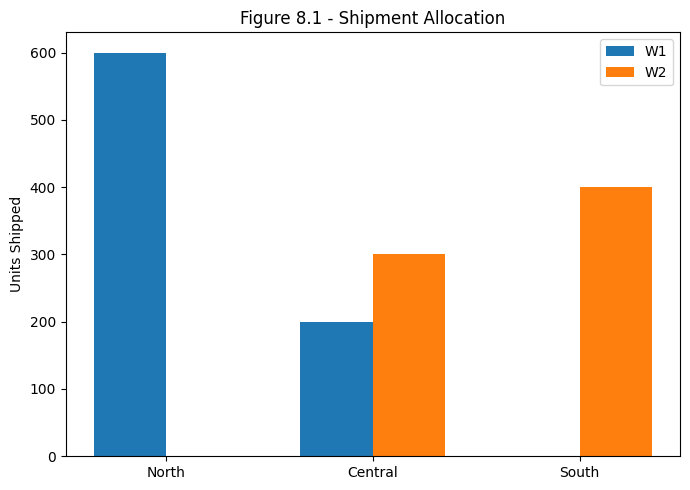

In [ ]:
# Figure 8.1 - Shipment Allocation
# Assumes these are already defined in memory:
#   warehouses (wh, capacity), markets (mkt, demand), cost (rows=regions, cols=W1,W2)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try SciPy for an optimal solution. If not available, fall back to a greedy that is feasible.
try:
    from scipy.optimize import linprog
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

# Variables: x = [W1->North, W1->Central, W1->South, W2->North, W2->Central, W2->South]
regions = list(markets["mkt"])
whs = list(warehouses["wh"])

# Objective costs in the same order as x
c = np.array([
    cost.loc["North","W1"],  cost.loc["Central","W1"],  cost.loc["South","W1"],
    cost.loc["North","W2"],  cost.loc["Central","W2"],  cost.loc["South","W2"]
], dtype=float)

# Demand constraints: sum over warehouses for each region equals demand
A_eq = np.zeros((len(regions), 6))
b_eq = markets["demand"].values.astype(float)
A_eq[0, [0, 3]] = 1   # North: W1N + W2N
A_eq[1, [1, 4]] = 1   # Central: W1C + W2C
A_eq[2, [2, 5]] = 1   # South: W1S + W2S

# Capacity constraints: sum over regions from each warehouse <= capacity
A_ub = np.zeros((len(whs), 6))
b_ub = warehouses["capacity"].values.astype(float)
A_ub[0, [0,1,2]] = 1  # W1 capacity
A_ub[1, [3,4,5]] = 1  # W2 capacity

bounds = [(0, None)] * 6

if HAVE_SCIPY:
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError(f"Transportation LP failed: {res.message}")
    x = res.x
else:
    # Greedy feasible fallback by ascending route cost
    routes = [
        ("W1","North", 0, 0, cost.loc["North","W1"]),
        ("W1","Central",0, 1, cost.loc["Central","W1"]),
        ("W1","South", 0, 2, cost.loc["South","W1"]),
        ("W2","North", 1, 3, cost.loc["North","W2"]),
        ("W2","Central",1, 4, cost.loc["Central","W2"]),
        ("W2","South", 1, 5, cost.loc["South","W2"]),
    ]
    routes.sort(key=lambda t: t[4])
    cap = warehouses.set_index("wh")["capacity"].to_dict()
    dem = markets.set_index("mkt")["demand"].to_dict()
    x = np.zeros(6, dtype=float)
    for wh, r, _, vidx, _ in routes:
        flow = min(cap[wh], dem[r])
        x[vidx] = flow
        cap[wh] -= flow
        dem[r] -= flow

# Build a tidy allocation table
alloc_df = pd.DataFrame({
    "Region": regions,
    "W1": [x[0], x[1], x[2]],
    "W2": [x[3], x[4], x[5]]
})
display(alloc_df)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(7,5))
bar_w = 0.35
pos = np.arange(len(alloc_df["Region"]))

ax.bar(pos - bar_w/2, alloc_df["W1"], width=bar_w, label="W1")
ax.bar(pos + bar_w/2, alloc_df["W2"], width=bar_w, label="W2")

ax.set_xticks(pos)
ax.set_xticklabels(alloc_df["Region"])
ax.set_ylabel("Units Shipped")
ax.set_title("Figure 8.1 - Shipment Allocation")
ax.legend()
plt.tight_layout()

# Optional save for Word or slides
# plt.savefig("figure_8_1_shipment_allocation.png", dpi=300)
plt.show()


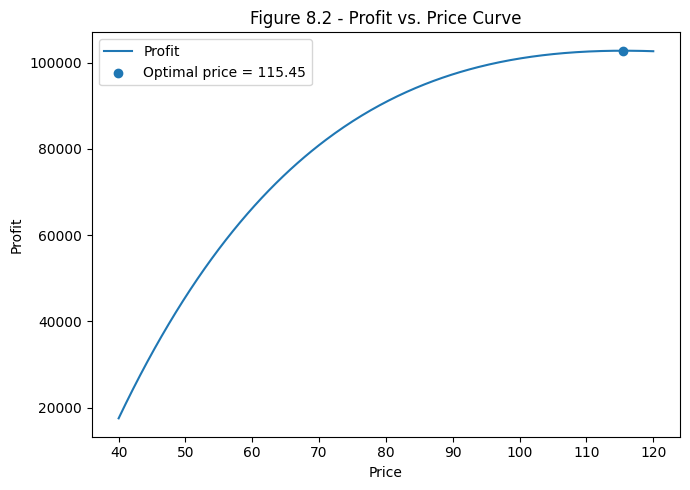

Optimal price: 115.45
Max profit: 102,785.86


In [ ]:
# Figure 8.2 - Profit vs. Price Curve
# Assumes these exist in memory:
# price_min, price_max, marginal_cost, baseline_demand, ref_price, elasticity
# Optional: bundles DataFrame with columns ['bundle','cost','uplift'] and promo_budget

import numpy as np
import matplotlib.pyplot as plt
import itertools

# 1) Optional promo uplift via simple knapsack over the small bundle set
uplift_units = 0.0
try:
    # Brute force all subsets since the bundle set is small
    best_uplift = 0.0
    best_cost = 0.0
    idxs = range(len(bundles))
    for r in range(len(bundles) + 1):
        for subset in itertools.combinations(idxs, r):
            sub_cost = float(bundles.iloc[list(subset)]["cost"].sum())
            sub_uplift = float(bundles.iloc[list(subset)]["uplift"].sum())
            if sub_cost <= promo_budget and sub_uplift > best_uplift:
                best_uplift = sub_uplift
                best_cost = sub_cost
    uplift_units = best_uplift  # treat uplift as additional demand units
except Exception:
    uplift_units = 0.0  # if bundles or promo_budget not present, ignore promo uplift

# 2) Build price grid and demand model
prices = np.linspace(price_min, price_max, 300)

# Exponential demand to avoid negatives
# demand(price) = baseline_demand * exp(-elasticity * (price - ref_price)) + uplift_units
base_curve = baseline_demand * np.exp(-elasticity * (prices - ref_price))
demand = base_curve + uplift_units

# 3) Profit curve
profit = (prices - marginal_cost) * demand

# 4) Find optimal price
opt_idx = np.argmax(profit)
opt_price = float(prices[opt_idx])
opt_profit = float(profit[opt_idx])

# 5) Plot
plt.figure(figsize=(7,5))
plt.plot(prices, profit, label="Profit")
plt.scatter([opt_price], [opt_profit], zorder=3, label=f"Optimal price = {opt_price:.2f}")
plt.xlabel("Price")
plt.ylabel("Profit")
plt.title("Figure 8.2 - Profit vs. Price Curve")
plt.legend()
plt.tight_layout()

# Optional save for Word
# plt.savefig("figure_8_2_profit_vs_price.png", dpi=300)

plt.show()

print(f"Optimal price: {opt_price:.2f}")
print(f"Max profit: {opt_profit:,.2f}")


## Review Questions

1. **In the shipping allocation problem, how many warehouses and how many markets are modeled?**

   A. 3 warehouses and 2 markets  
   B. 2 warehouses and 3 markets  
   C. 2 warehouses and 2 markets  
   D. 3 warehouses and 3 markets  

2. **What is the decision-variable order used for the linear program (the `x` vector) in the shipment allocation section?**

   A. \[North->W1, Central->W1, South->W1, North->W2, Central->W2, South->W2\]  
   B. \[W1->North, W1->Central, W1->South, W2->North, W2->Central, W2->South\]  
   C. \[W1 total, W2 total, North total, Central total, South total\]  
   D. \[W1->North, W2->North, W1->Central, W2->Central, W1->South, W2->South\]  

3. **What is the promotional budget used in the bundle selection problem (`promo_budget`)?**

   A. 90  
   B. 120  
   C. 150  
   D. 200  

4. **Which optimization approach is used to choose the best set of promo bundles under the budget constraint?**

   A. Gradient descent  
   B. K-means clustering  
   C. Dynamic programming knapsack  
   D. Linear regression  

5. **What demand model form is used for pricing (ignoring any optional promo uplift)?**

   A. `baseline_demand * (1 - elasticity * (p - ref_price))`  
   B. `baseline_demand * exp(-elasticity * (p - ref_price))`  
   C. `baseline_demand / (1 + elasticity * p)`  
   D. `baseline_demand + elasticity * (p - ref_price)`  
